Dans cette partie il s'agit de la découverte de deux méthodes de réduction de dimensions, le _t-SNE_ et l'_auto-encodeur_.  
  
On a vu dans la partie précédente exploratoire que l'analyse en composantes principales n'est pas pertinente pour nos données pré-traitées, notamment en vue de visualisation, puisque les trois premières composantes ensemble n'expliquent même pas 20% des variances totales. Ainsi, on doit bien chercher d'autres méthodes de réduction de dimensions, qui serveront plus tard à révéler des pistes dans les données et permet de visualiser les différentes approches de clustering.  

On importe d'abord les librairies qu'il faut et les données. Attention cette partie contient les codes orignaux de la création des modèles et de la fonction qui trace. Mais lors de la première exécution on a sauvegardé les modèles et la fonction dans le répertoire. Donc il ne reste à l'utilisateur que de les charger. Il n'a pas forcément besoin d'entraîner les modèles à nouveau, qui pourrait prendre du temps selon la puissance de sa machine.  
  
L'implémentation de l'auto-encodeur ici est faite avec `keras`.

In [1]:
import pandas as pd
import numpy as np
import dill as pickle

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Input
from keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline
from pylab import get_cmap

complete_preprocessed = pd.read_pickle("preprocessed")
complete = pd.read_pickle("complete")
tsne = pickle.load(open("tSNE", "rb"))
complete.columns.values
drawData = pickle.load(open("drawData", "rb"))

Using TensorFlow backend.


On crée la fonction qui tracera plus tard les données entraînées en 2D. Encore une fois, pas besoin de l'exécuter juste pour l'utilisation.

In [7]:
def drawData(X_scores, color_column, titre="2D Viz", legend_loc = "upper right"):
    x_max = X_scores[:, 0].max()
    x_min = X_scores[:, 0].min()
    y_max = X_scores[:, 1].max()
    y_min = X_scores[:, 1].min()
    
    len_x = x_max - x_min
    len_y = y_max - y_min

    plt.title(titre)
    
    color_class = color_column.unique()
    color_num = color_class.size
    print(color_num)
    cm = get_cmap('gist_rainbow')
    cgen = (cm(1.*i/color_num) for i in range(color_num))
    
    plt.scatter(X_scores[:, 0], X_scores[:, 1], c=color_column)
    
    plt.axis('tight')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

Maintenant on va essayer la méthode de t-SNE, _t-distributed stochastic neighbor embedding_. On entraîne le modèle avec toutes les données. Attention pour répéter l'entraînement, dé-commenter les codes et commenter la dernière ligne. Sinon la dernière ligne va charger les coordonnées déjà entraînées.

In [4]:
# tsne = TSNE(n_components=2, random_state=0, perplexity=50) # Ici 50 semble mieux que 30.
# df_tsne_2d = tsne.fit_transform(complete_preprocessed)

df_tsne_2d = tsne.embedding_
df_tsne_2d

array([[-62.41272354, -12.30766678],
       [-34.72774506,  38.10370636],
       [ 27.97219849, -32.43561172],
       ..., 
       [-23.58042908, -12.54105186],
       [ 25.07641602,  -4.43594074],
       [ 19.82580948, -54.06336212]], dtype=float32)

Maintenant on échantillonne 2.000 observations pour la visualisation en utilisant de différents critères de coloration.   
Dans la coloration de notre choix, plus la couleur d'un point est claire, plus sa valeur est élevée.

In [23]:
index_sampled = np.random.randint(0, complete.shape[0], 2000)
df_pre_sampled = complete_preprocessed.iloc[index_sampled]
df_sampled = complete.iloc[index_sampled]
echatillon = index_sampled

index_sampled[:5]

array([ 4568,  5296, 38880, 21860, 28193])

2
2
24
14
6
15


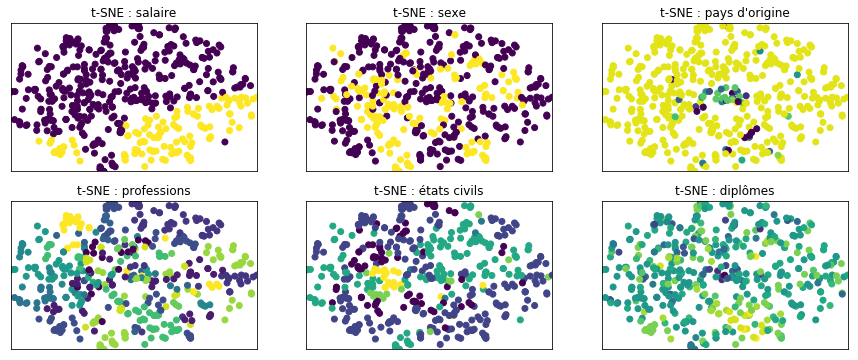

In [61]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
drawData(df_tsne_2d[echantillon, :], complete_preprocessed.loc[echantillon, "salary_>50K"],
        titre = "t-SNE : salaire")
plt.xticks([])
plt.yticks([])  
plt.subplot(2, 3, 2)
drawData(df_tsne_2d[echantillon, :], complete_preprocessed.loc[echantillon, "isFemale"],
        titre = "t-SNE : sexe")
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 3)
drawData(df_tsne_2d[echantillon, :],
        complete.loc[echantillon, "nativeCountry"].astype('category').cat.codes,
        titre = "t-SNE : pays d'origine")
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 4)
drawData(df_tsne_2d[echantillon, :],
        complete.loc[echantillon, "occupation"].astype('category').cat.codes,
        titre = "t-SNE : professions")
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 5)
drawData(df_tsne_2d[echantillon, :],
        complete.loc[echantillon, "maritalStatus"].astype('category').cat.codes,
        titre = "t-SNE : états civils")
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 6)
drawData(df_tsne_2d[echantillon, :],
        complete.loc[echantillon, "educationNr"],
        titre = "t-SNE : diplômes")
plt.xticks([])
plt.yticks([])
plt.show()

Conclusion de la constatation : voir rapport.

On a vu que la méthode de t-SNE laisse retrouver des pistes dans données. Pourtant, la visualisation en soi ne forme pas de sous-groupes de façon naturelle. Notre deuxième méthode _auto-encodeur_ serait-elle compétente à ce point-là ? Construisons maintenant le médèle. On utilise un encodeur avec une couche cachée de 10 neuronnes. Sa dimension de sortie est 2 puisqu'on voudrait l'utiliser plus tard pour la visualisation. La fonction de loss qu'on prend c'est l'erreur quadratique moyenne.

In [10]:
# in order to plot in a 2D figure
encoding_dim = 2

# this is our input placeholder
input_var = Input(shape=(48, ))

# encoder layers
encoded = Dense(10, activation='relu')(input_var)
encoder_output = Dense(encoding_dim)(encoded)

# decoder layers
decoded = Dense(10, activation='relu')(encoder_output)
decoded = Dense(48, activation='tanh')(decoded)

# construct the autoencoder model
autoencoder = Model(input=input_var, output=decoded)

# construct the encoder model for plotting
encoder = Model(input=input_var, output=encoder_output)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


On l'entraîne :

In [11]:
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(complete_preprocessed, complete_preprocessed,
                nb_epoch=10,
                batch_size=10,
                shuffle=True)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/10
48842/48842 [==============================] - 7s 139us/step - loss: 0.0496
Epoch 2/10
48842/48842 [==============================] - 7s 134us/step - loss: 0.0412
Epoch 3/10
48842/48842 [==============================] - 7s 134us/step - loss: 0.0398
Epoch 4/10
48842/48842 [==============================] - 7s 134us/step - loss: 0.0391
Epoch 5/10
48842/48842 [==============================] - 7s 135us/step - loss: 0.0386
Epoch 6/10
48842/48842 [==============================] - 7s 135us/step - loss: 0.0382
Epoch 7/10
48842/48842 [==============================] - 7s 135us/step - loss: 0.0380
Epoch 8/10
48842/48842 [==============================] - 7s 135us/step - loss: 0.0378
Epoch 9/10
48842/48842 [==============================] - 7s 134us/step - loss: 0.0377
Epoch 10/10
48842/48842 [==============================] - 7s 134us/step - loss: 0.0376


2
2
38
14
6
16


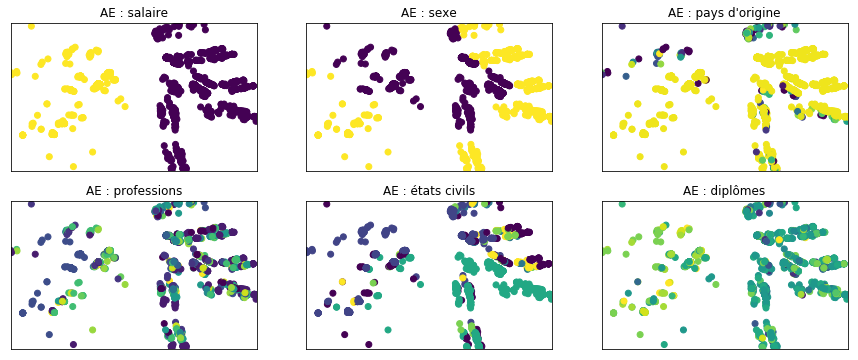

In [64]:
df_encoded = encoder.predict(df_pre_sampled, batch_size = 20)

plt.figure(figsize=(15, 6))
plt.subplot(2, 3, 1)
drawData(df_encoded, df_pre_sampled["salary_>50K"],
        titre = "AE : salaire")
plt.xticks([])
plt.yticks([])  
plt.subplot(2, 3, 2)
drawData(df_encoded, df_pre_sampled["isFemale"],
        titre = "AE : sexe")
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 3)
drawData(df_encoded,
        df_sampled["nativeCountry"].astype('category').cat.codes,
        titre = "AE : pays d'origine")
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 4)
drawData(df_encoded,
        df_sampled["occupation"].astype('category').cat.codes,
        titre = "AE : professions")
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 5)
drawData(df_encoded,
        df_sampled["maritalStatus"].astype('category').cat.codes,
        titre = "AE : états civils")
plt.xticks([])
plt.yticks([])
plt.subplot(2, 3, 6)
drawData(df_encoded,
        df_sampled["educationNr"],
        titre = "AE : diplômes")
plt.xticks([])
plt.yticks([])
plt.show()

Conclusion de la constatation : voir rapport.

In [44]:
for maritalStatus in ["maritalStatus_Never-married",
                     "maritalStatus_Divorced"]:
    print(maritalStatus, ": ", df_pre_sampled[maritalStatus].corr(
        df_pre_sampled["salary_<=50K"]))
    
((df_sampled["maritalStatus"] == "Married-civ-spouse") * 1).corr(df_pre_sampled["salary_<=50K"])

maritalStatus_Never-married :  0.3220172110532712
maritalStatus_Divorced :  0.11627579451617734


-0.4706000146763544

Maintenant on va sauvegarder les modèles de t-SNE et d'auto-encodeur pour l'utilisation ultérieure.

In [65]:
filename_tsne = "tSNE"
pickle.dump(tsne, open(filename_tsne, 'wb'))

filename_autoencoder = "autoencoder"
pickle.dump(df_encoded, open(filename_autoencoder, 'wb'))

filname_sample_index = "simpleIndex"
pickle.dump(index_sampled, open(filname_sample_index, 'wb'))